In [133]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from scipy import signal
import zplane as zp
#import control as ctrl


Funciones

In [147]:
def read(archivo,Fs):
    with open(archivo,"r") as senhal:
        next(senhal)
        next(senhal)
        next(senhal)
        senhal=senhal.readlines()
        amplitude=[]
        for linea in senhal:
            x=int(linea.split()[5])
            amplitude.append(x)
        
        n=[i for i in range (len(amplitude))]
        n=np.array(n)
        t=n/Fs
    return t,amplitude

def plot(x,y,title,xlabel,ylabel):        
    plt.plot(x,y)
    #plt.xlim(min(x),max(x))
    #plt.ylim(min(y),max(y))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)    

def fft(y,Fs):
    Ts=1/Fs
    N=len(y)
    n=np.arange(N)
    #n=np.linspace(0,N,1)
    fourier=np.fft.fft(y)        
    Hz=np.fft.fftfreq(N,Ts)
    return Hz,fourier

def lowPassFIR(Fp,Fstop,Fsam, x):
    #Fp: At this frequency, magnitude begin decreasing
    #Fstop: From this frequency is where stopband start
    wp=2*np.pi*Fp/Fsam
    wstop=2*np.pi*Fstop/Fsam
    wc=(wp+wstop)/2 #rad/sample
    dw=wstop-wp
    """
    Estos parametros son importantes si se quiere analizar entre otras ventanas, en
    nuestro caso, solo utilizaremos la ventana blackman, ya que es una de las ventanas 
    más potentes.

    Rp=20*np.log10(1-e1)
    Rs=20*np.log10(e2)
    R=[Rp,Rs]
    R=min(R)
    """

    #Blackman
    M=int(np.floor(12*np.pi/dw))
    h_fir=signal.firwin(M+1,wc/np.pi,window='blackman')
    if len(x)==0:
        return h_fir,1
    else:
        y=signal.lfilter(h_fir,1,x)
        return h_fir,1,y

def bandPassFilter_IIR(lowCut,highCut,order,Fs,x):
    #Simple Filter
    norm_low=lowCut/(0.5*Fs)
    norm_high=highCut/(0.5*Fs)
    b, a = signal.butter(order, [norm_low, norm_high], btype='band')
    if len(x)==0:
        return b,a
    else:
        y=signal.lfilter(b,a,x)
        return b,a,y
def butterLow(orden,fc,fs,x):
    b, a = signal.butter(orden, fc / (0.5 * fs), btype='low', analog=False)
    w, _ = signal.freqz(b, a, worN=8000)
    frecuencias = (w / np.pi) * (fs / 2)
    y=signal.lfilter(b,a,x)
    return frecuencias,y

def zplane(b, a):
    """Plot the poles and zeros of a discrete-time system in the z-plane."""
    # Obtener polos y ceros          
    zeros, poles, _ = signal.tf2zpk(b, a)

    # Crear el gráfico
    plt.figure(figsize=(6, 6))
    
    # Graficar el círculo unitario
    unit_circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
    plt.gca().add_artist(unit_circle)
    
    # Graficar ceros en azul
    plt.scatter(np.real(zeros), np.imag(zeros), color='blue', label='Ceros', s=50)
    
    # Graficar polos en rojo
    plt.scatter(np.real(poles), np.imag(poles), color='red', marker='x', label='Polos', s=50)
    
    # Definir el límite de la gráfica
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    
    # Etiquetas y leyenda
    plt.axhline(0, color='black',linewidth=1)
    plt.axvline(0, color='black',linewidth=1)
    plt.title('Plano Z: Polos y Ceros')
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginaria')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.gca().set_aspect('equal', adjustable='box')
    
    # Mostrar el gráfico
    plt.show()


Low pass filter
- h[n]: unit impulse response --> h
- H(e^jw): Frequency respones of the system --> H
- H(z): Transfer Function 

C:\Users\51913\AppData\Local\Temp\ipykernel_17892\3029364877.py:37: RuntimeWarning: divide by zero encountered in log10
  dB_magIIR=20*np.log10(magnitudeIIR)


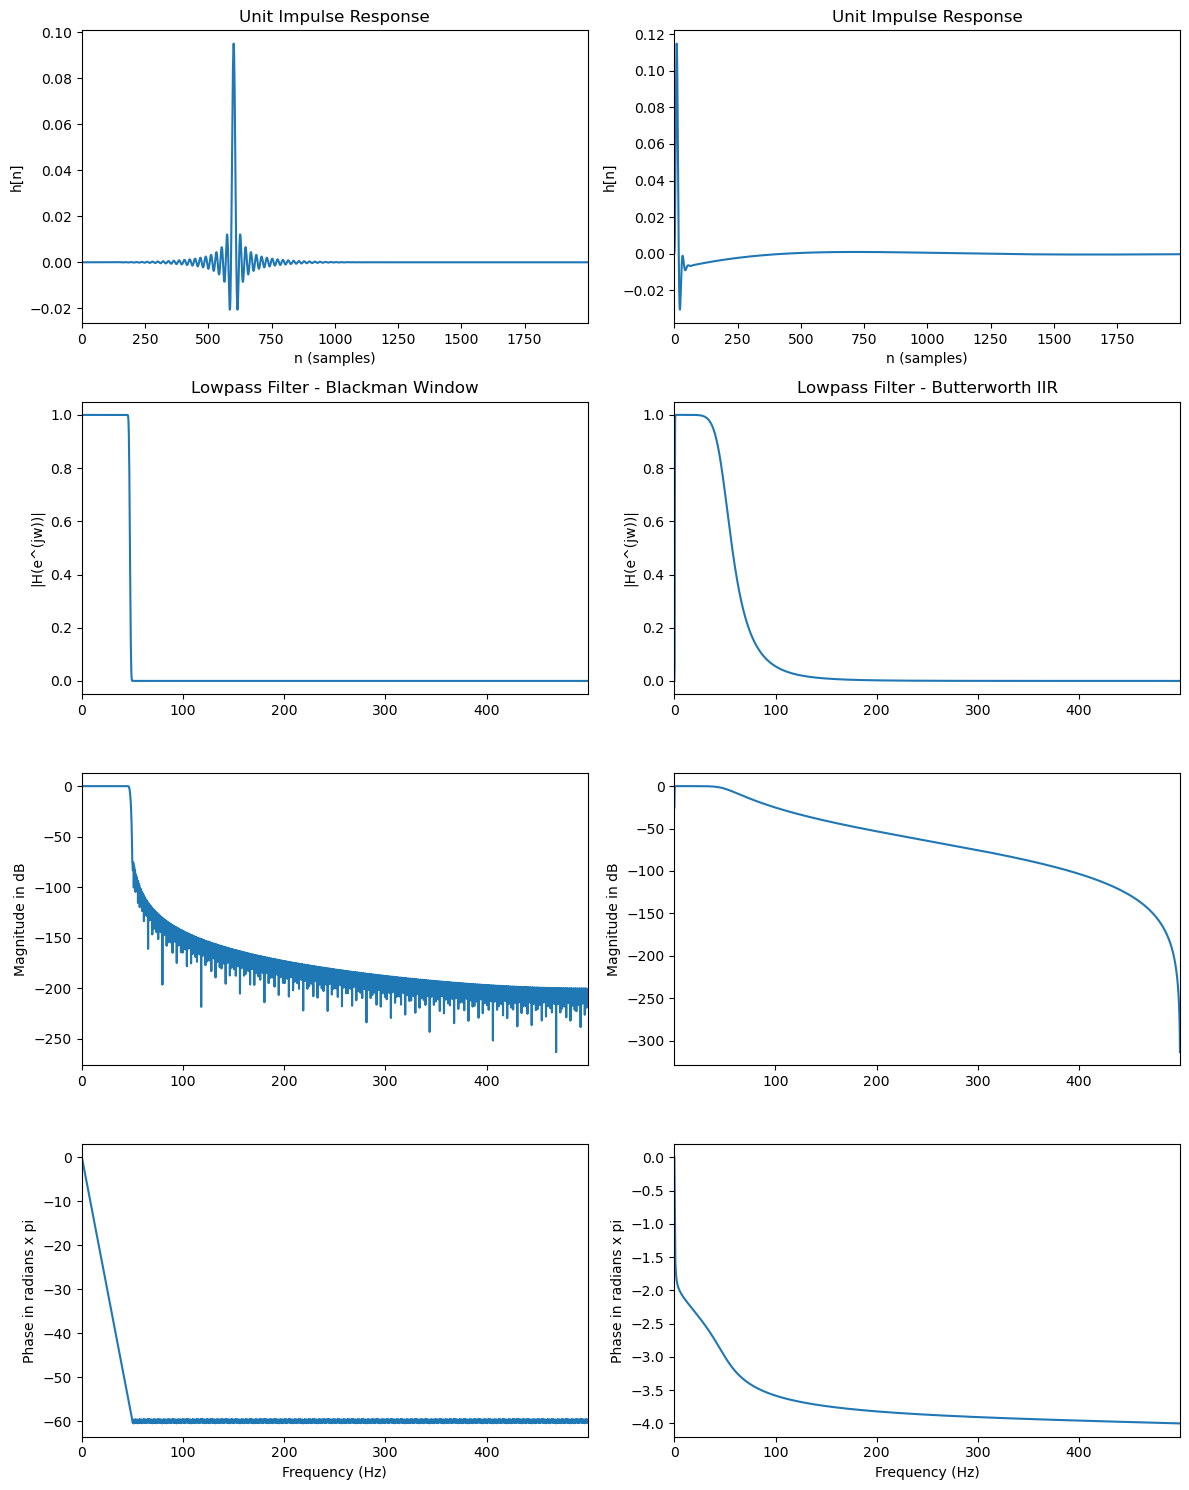

"\nFrom the graphics below:\n- The response to the unit impulse (h[n]) of the system shows a low-intensity peak, which \ngradually decreases until it converges to 0. Since the sum of the values of the \nimpulse response is finite, we can conclude that this low-pass filter is BIBO (Bounded Input - Bounded Output Stability)\nstable.\n-The frequency response of this sytems shows a passband, transition band and stopband. \nFor this example, I tried to make it selective, that is, transition band shoul be a low value. Although it does not \nseem like it.\n-When we see the graphic with normal magnitude, it's hard to distinguish variation, I mean ripples are not easy to \nsee, that's why I graphed the magnitude in dB with a reference value equal to 1, it allow us to see how the ripple \nvariate along all the freq. Especially in the stopband, there are many lobes. This lobes are less visible when \nthe filter becomes more selective, df tend to 0. However, the computacional requirement increases

In [135]:
#Unit impulse

n=np.arange(2000)
unit_impulse=np.zeros(len(n))
unit_impulse[0]=1


#Filter design parameters

Fs=1000 #This sampling frequency comes from Bitalino


#For ECG
LowFc=0.5
HighFc=50
order=4
b,aIIR,hIIR=bandPassFilter_IIR(LowFc,HighFc,order,Fs,unit_impulse)
h_coef,aFIR,hFIR=lowPassFIR(45,50,Fs,unit_impulse)#This is a FIR low pass filter 


wFIR,HFIR=signal.freqz(h_coef,aFIR,2048)
wIIR,HIIR=signal.freqz(b,aIIR,2048)

frequenciesFIR=wFIR*Fs/(2*np.pi)
frequenciesIIR=wIIR*Fs/(2*np.pi)

magnitudeFIR=np.abs(HFIR)
magnitudeIIR=np.abs(HIIR)

dB_magFIR=20*np.log10(magnitudeFIR)
dB_magIIR=20*np.log10(magnitudeIIR)

fig=plt.figure(figsize=(12,15))

plt.subplot(4,2,1)
plot(n,hFIR,"Unit Impulse Response","n (samples)","h[n]")
plt.autoscale(True, axis='x', tight=True)


plt.subplot(4,2,3)
plot(frequenciesFIR,magnitudeFIR,"Lowpass Filter - Blackman Window","","|H(e^(jw))|")
plt.autoscale(True, axis='x', tight=True)


plt.subplot(4,2,5)
plot(frequenciesFIR,dB_magFIR,"","","Magnitude in dB")
plt.autoscale(True, axis='x', tight=True)

plt.subplot(4,2,7)
plot(frequenciesFIR,np.unwrap(np.angle(HFIR))/np.pi,"","Frequency (Hz)","Phase in radians x pi")
plt.autoscale(True, axis='x', tight=True)

plt.subplot(4,2,2)
plot(n,hIIR,"Unit Impulse Response","n (samples)","h[n]")
plt.autoscale(True, axis='x', tight=True)


plt.subplot(4,2,4)
plot(frequenciesIIR,magnitudeIIR,"Lowpass Filter - Butterworth IIR","","|H(e^(jw))|")
plt.autoscale(True, axis='x', tight=True)

plt.subplot(4,2,6)
plot(frequenciesIIR,dB_magIIR,"","","Magnitude in dB")
plt.autoscale(True, axis='x', tight=True)

plt.subplot(4,2,8)
plot(frequenciesIIR,np.unwrap(np.angle(HIIR))/np.pi,"","Frequency (Hz)","Phase in radians x pi")
plt.autoscale(True, axis='x', tight=True)

plt.tight_layout()
plt.show()


From the graphics below:
- The response to the unit impulse (h[n]) of the system shows a low-intensity peak, which 
gradually decreases until it converges to 0. Since the sum of the values of the 
impulse response is finite, we can conclude that this low-pass filter is BIBO (Bounded Input - Bounded Output Stability)
stable.
-The frequency response of this sytems shows a passband, transition band and stopband. 
For this example, I tried to make it selective, that is, transition band shoul be a low value. Although it does not 
seem like it.
-When we see the graphic with normal magnitude, it's hard to distinguish variation, I mean ripples are not easy to 
see, that's why I graphed the magnitude in dB with a reference value equal to 1, it allow us to see how the ripple 
variate along all the freq. Especially in the stopband, there are many lobes. This lobes are less visible when 
the filter becomes more selective, df tend to 0. However, the computacional requirement increases.

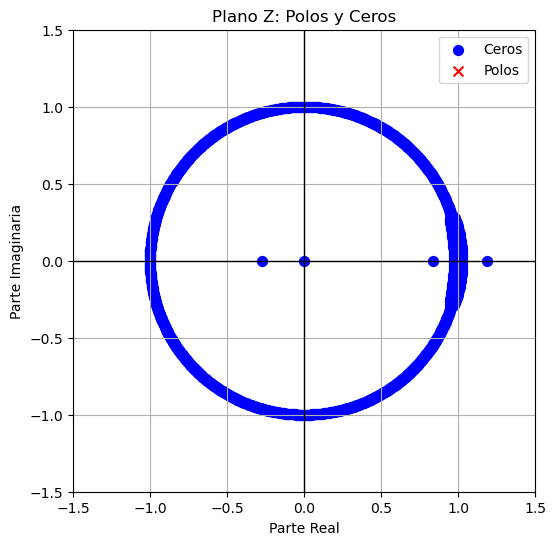

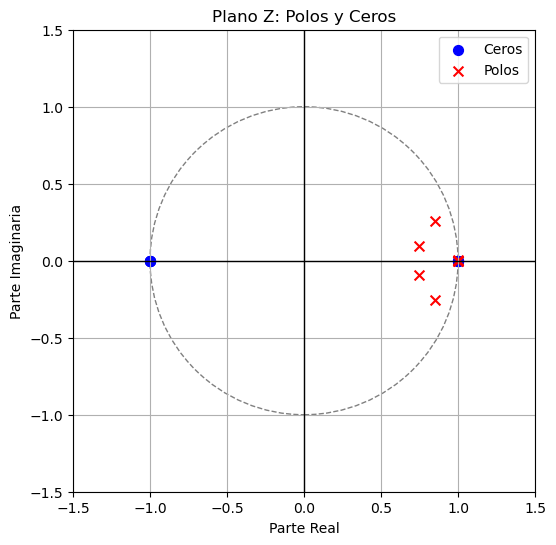

In [136]:

zplane(h_coef,1)
zplane(b,aIIR)

For the plane of poles and zeros, in the second graph, the convergence region is outward, so it contains the unit circumference.

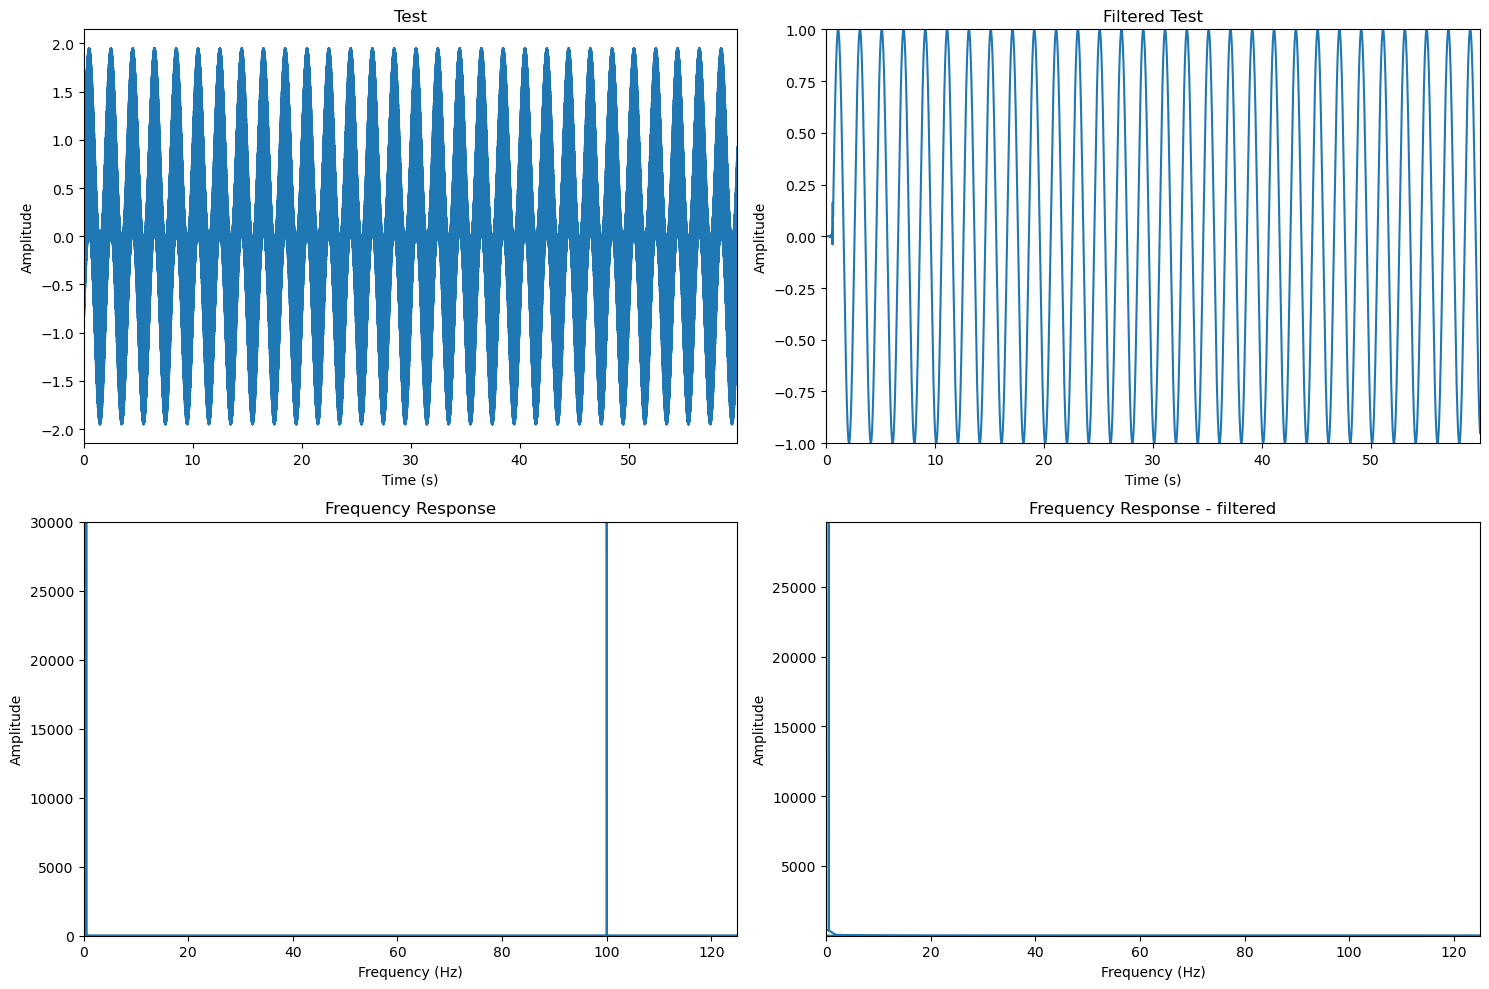

In [137]:
#Demostrative Example

n=np.arange(60000)
Fs=1000
t=n*1/Fs
y=np.sin(2*np.pi*0.5*t)+np.sin(2*np.pi*100*t)
freq,amplitude=fft(y,Fs)

fig=plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot(t,y,"Test","Time (s)","Amplitude")
plt.autoscale(True, axis='x', tight=True)

plt.subplot(2,2,3)
plot(freq,abs(amplitude),"Frequency Response","Frequency (Hz)","Amplitude")
plt.autoscale(True, axis='x', tight=True)
plt.autoscale(True, axis='y', tight=True)
plt.xlim(0,125)


y_filtered=signal.lfilter(h_coef,1,y)
freq,amplitude=fft(y_filtered,Fs)
plt.subplot(2,2,2)
plot(t,y_filtered,"Filtered Test","Time (s)","Amplitude")
plt.autoscale(True, axis='x', tight=True)
plt.autoscale(True, axis='y', tight=True)

plt.subplot(2,2,4)
plot(freq,np.abs(amplitude),"Frequency Response - filtered","Frequency (Hz)","Amplitude")
plt.autoscale(True, axis='x', tight=True)
plt.autoscale(True, axis='y', tight=True)
plt.xlim(0,125)

plt.tight_layout()
plt.show()

Ejecución de diferentes ventanas

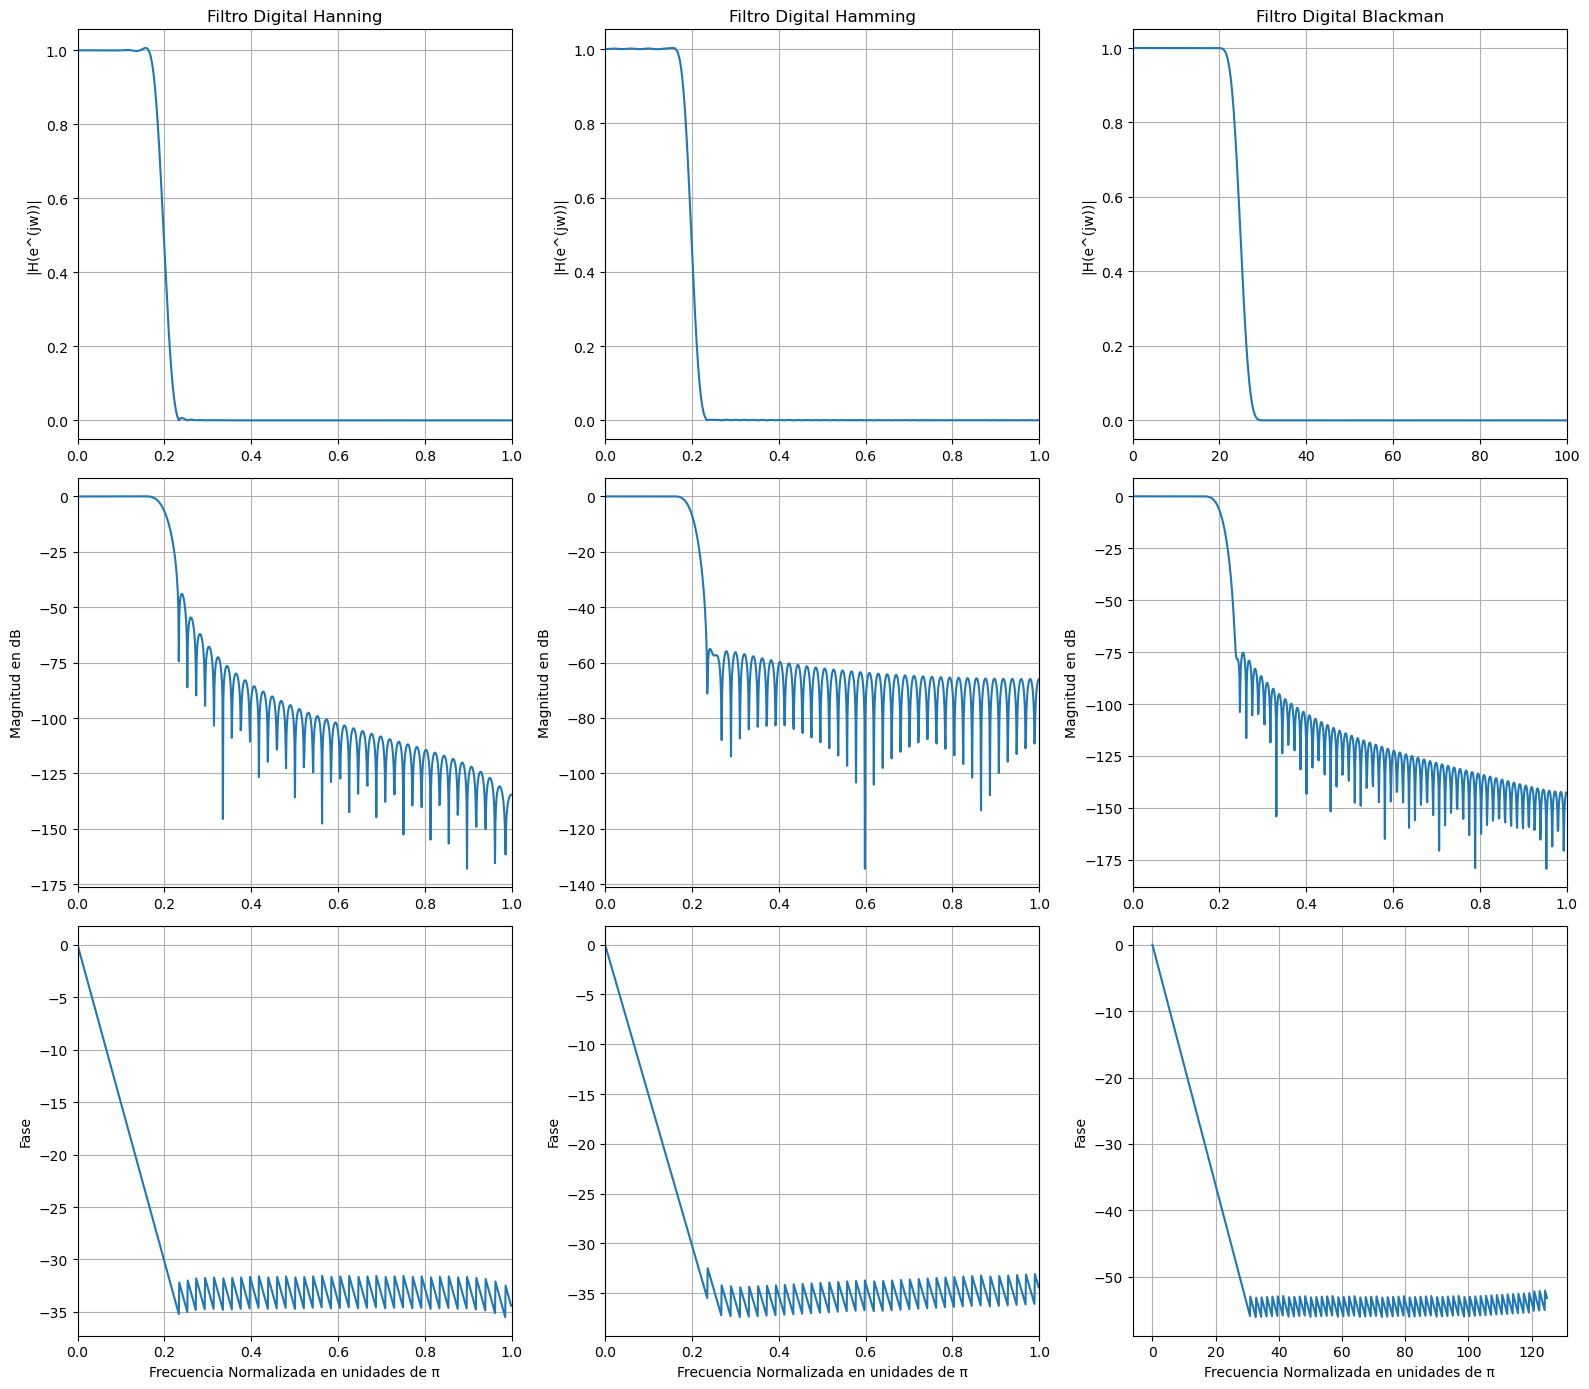

In [138]:
# Arbitrary examples
Fs = 250  # Sampling Frequency
dw = 0.26  # Transition band(rad/sample)
ws = 2 * np.pi * 30 / Fs  # cutting frequency in the stopband(en rad/sam)
wp = ws - dw  # cutting frequency in the passband
wc = (wp + ws) / 2  # Central cutting frequency

# Ripple en banda de paso y stop
d1 = 0.05
d2 = 0.07

# Convertir ripple a dB, los errores en la banda de rechazo y paso
# Estos nos indican que ventanas son las más adecuadas

dBd1 = 20 * np.log10(d1)
dBd2 = 20 * np.log10(d2)

# ORDER
M_hann = int(np.floor(8 * np.pi / dw))
M_hamm = int(np.floor(8 * np.pi / dw))
M_blac = int(np.floor(12 * np.pi / dw))

# WINDOWS
h_hann = signal.firwin(M_hann + 1, wc / np.pi, window='hann')
h_hamm = signal.firwin(M_hamm + 1, wc / np.pi, window='hamming')
h_blac = signal.firwin(M_blac + 1, wc / np.pi, window='blackman')

# FREQUENCIES
N = 2048  # Resolución
n = np.arange(N)
w = (2 * np.pi / N) * n
w = np.unwrap(np.fft.fftshift(w - 2 * np.pi))
w = w[w >= 0]

# Frequency response
Hz_hann = signal.freqz(h_hann, worN=w)
Hz_hamm = signal.freqz(h_hamm, worN=w)
Hz_blac = signal.freqz(h_blac, worN=w)

# Magnitude
mag_imp_hann = np.abs(Hz_hann[1])
db_magimp_hann = 20 * np.log10(mag_imp_hann)
phase_imp_hann = np.unwrap(np.angle(Hz_hann[1]))

mag_imp_hamm = np.abs(Hz_hamm[1])
db_magimp_hamm = 20 * np.log10(mag_imp_hamm)
phase_imp_hamm = np.unwrap(np.angle(Hz_hamm[1]))

mag_imp_blac = np.abs(Hz_blac[1])
db_magimp_blac = 20 * np.log10(mag_imp_blac)
phase_imp_blac = np.unwrap(np.angle(Hz_blac[1]))


plt.figure(figsize=(16, 14))

# Hanning
plt.subplot(3,3,1)
plt.plot(w / np.pi, mag_imp_hann)
plt.xlim(0, 1)
plt.title('Filtro Digital Hanning')
plt.ylabel('|H(e^(jw))|')
plt.grid(True)

plt.subplot(3,3,4)
plt.plot(w / np.pi, db_magimp_hann)
plt.xlim(0, 1)
plt.ylabel('Magnitud en dB')
plt.grid(True)

plt.subplot(3,3,7)
plt.plot(w / np.pi, phase_imp_hann)
plt.xlabel('Frecuencia Normalizada en unidades de π')
plt.xlim(0, 1)
plt.ylabel('Fase')
plt.grid(True)

# Hamming
plt.subplot(3,3,2)
plt.plot(w / np.pi, mag_imp_hamm)
plt.xlim(0, 1)
plt.title('Filtro Digital Hamming')
plt.ylabel('|H(e^(jw))|')
plt.grid(True)

plt.subplot(3,3,5)
plt.plot(w / np.pi, db_magimp_hamm)
plt.xlim(0, 1)
plt.ylabel('Magnitud en dB')
plt.grid(True)

plt.subplot(3,3,8)
plt.plot(w / np.pi, phase_imp_hamm)
plt.xlabel('Frecuencia Normalizada en unidades de π')
plt.xlim(0, 1)
plt.ylabel('Fase')
plt.grid(True)

# Blackman
plt.subplot(3,3,3)
plt.plot(w*Fs / (2*np.pi), mag_imp_blac)
plt.xlim(0, 100)
plt.title('Filtro Digital Blackman')
plt.ylabel('|H(e^(jw))|')
plt.grid(True)

plt.subplot(3,3,6)
plt.plot(w / np.pi, db_magimp_blac)
plt.xlim(0, 1,)
plt.ylabel('Magnitud en dB')
plt.grid(True)

plt.subplot(3,3,9)
plt.plot(w*Fs / (2*np.pi), phase_imp_blac)
plt.xlabel('Frecuencia Normalizada en unidades de π')
#plt.xlim(0, 1)
plt.ylabel('Fase')
plt.grid(True)

plt.tight_layout()
plt.show()

From the graphs obtained, we see how the blackman window attenuates the frequencies better in the rejection band, the lobes in this window are shorter compared to the hanning and hamming window

ECG 

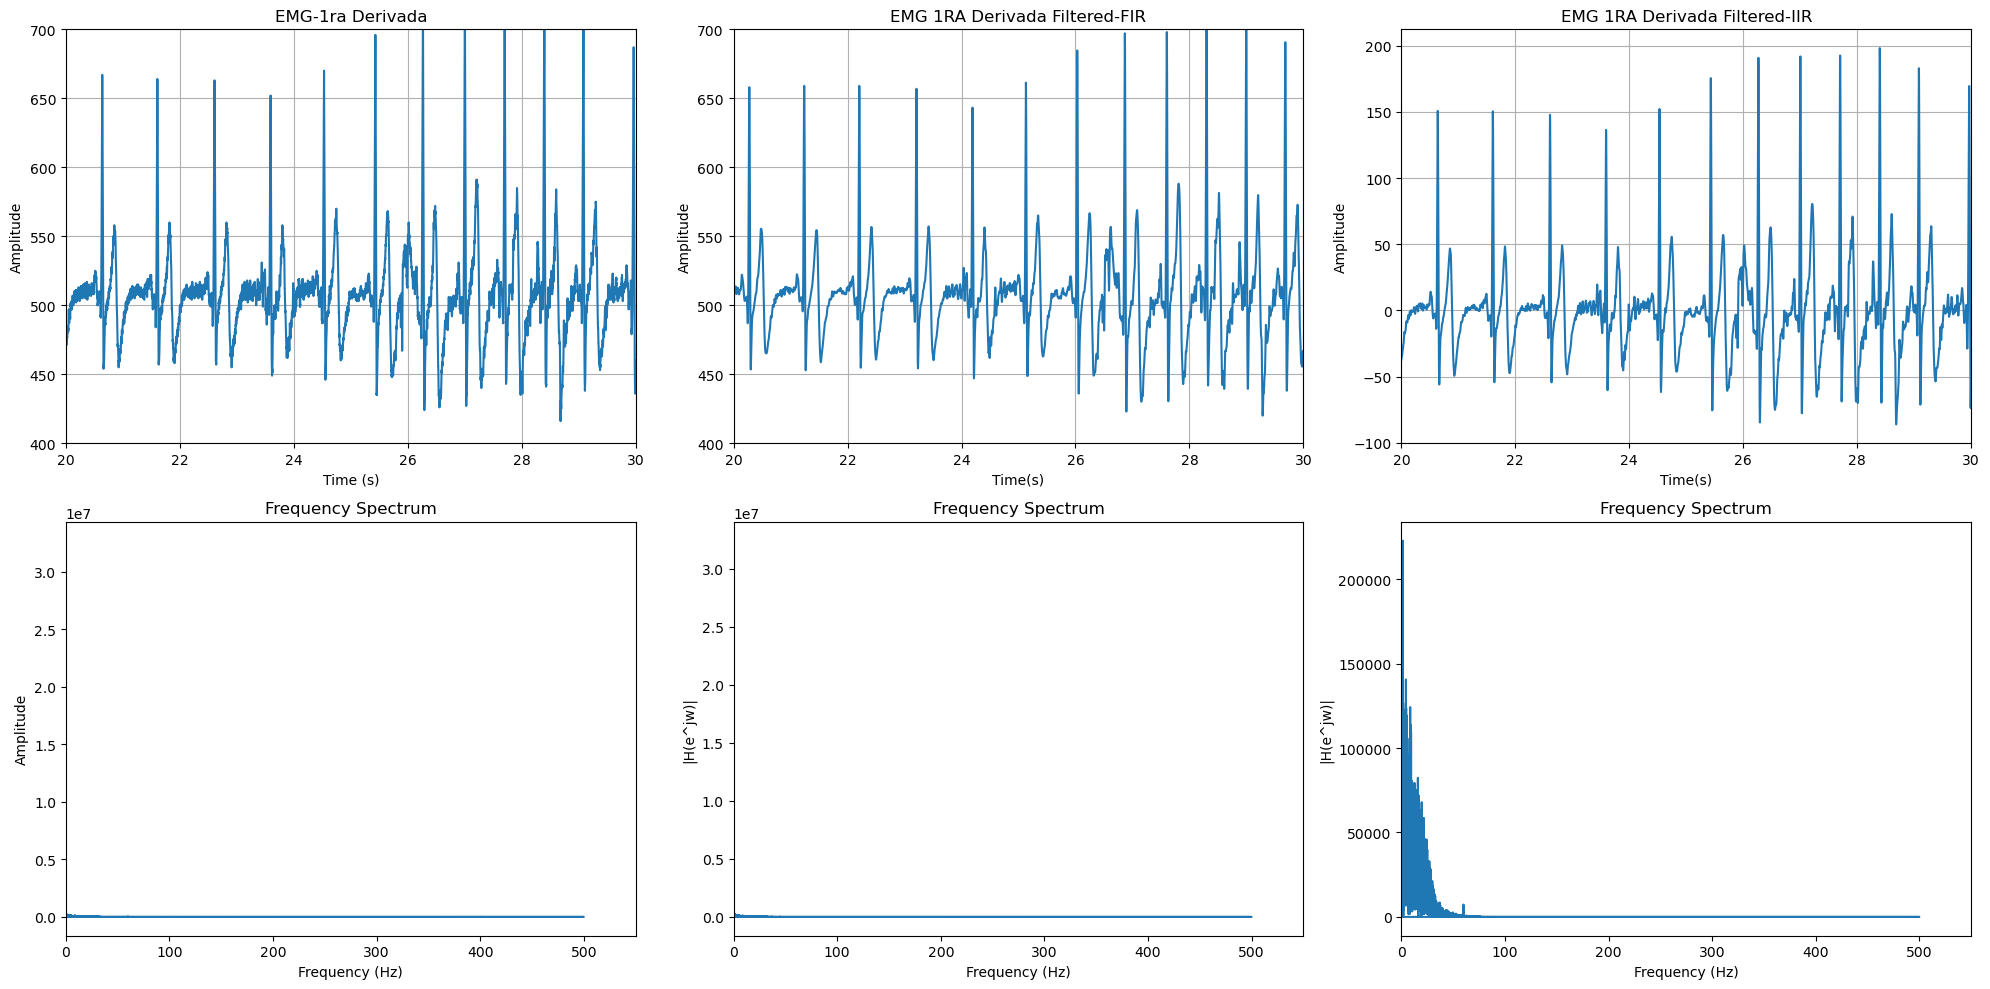

In [139]:
Fs=1000 #From Bitalino
t,y=read("1raDerivada.txt",Fs)
freq,amplitude=fft(y,Fs)

fig=plt.figure(figsize=(20,10)) #Size of the window where graphs are shown

#Time signal
plt.subplot(2,3,1)
plot(t,y,"EMG-1ra Derivada","Time (s)","Amplitude")
plt.autoscale(True, axis='x', tight=True)
plt.xlim(20,30)
plt.ylim(400,700)
plt.grid()

#Frequency signal
plt.subplot(2,3,4)
plot(freq,np.abs(amplitude),"Frequency Spectrum","Frequency (Hz)","Amplitude")
plt.xlim(left=0)

y_filtered=signal.lfilter(h_coef,1,y)
freq,amplitude=fft(y_filtered,Fs)

plt.subplot(2,3,2)
plot(t,y_filtered,"EMG 1RA Derivada Filtered-FIR","Time(s)","Amplitude")
plt.grid()
plt.autoscale(True, axis='x', tight=True)
plt.xlim(20,30)
plt.ylim(400,700)

plt.subplot(2,3,5)
plot(freq,np.abs(amplitude),"Frequency Spectrum","Frequency (Hz)","|H(e^jw)|")
plt.xlim(left=0)

y_filtered=signal.filtfilt(b,aIIR,y)
freq,amplitude=fft(y_filtered,Fs)

plt.subplot(2,3,3)
plot(t,y_filtered,"EMG 1RA Derivada Filtered-IIR","Time(s)","Amplitude")
plt.grid()
plt.autoscale(True, axis='x', tight=True)
plt.xlim(20,30)


plt.subplot(2,3,6)
plot(freq,np.abs(amplitude),"Frequency Spectrum","Frequency (Hz)","|H(e^jw)|")
plt.xlim(left=0)

plt.tight_layout()
plt.show()

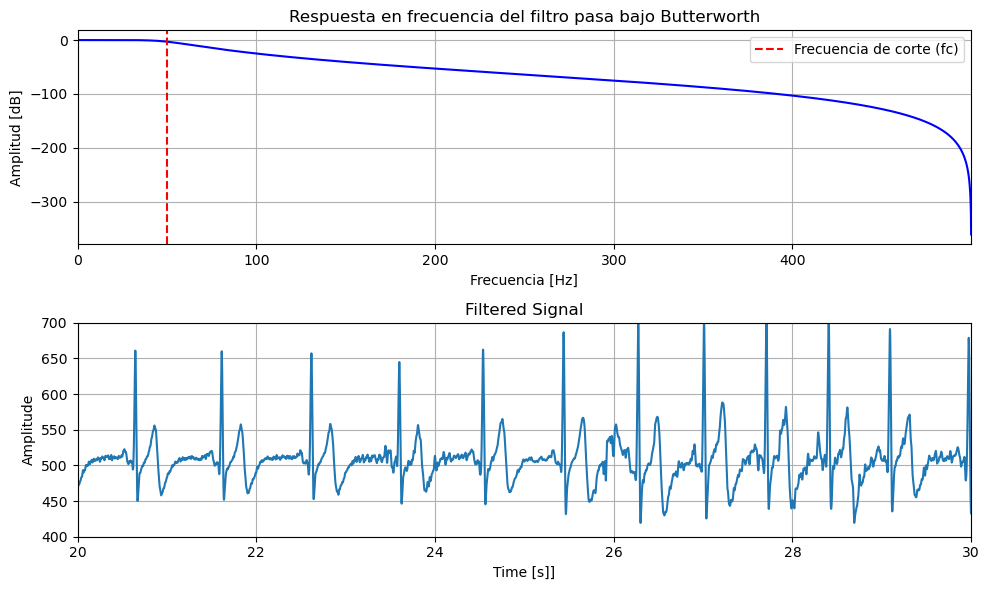

In [140]:
orden = 4
fs = 1000
fc = 50

# Design
b, a = signal.butter(orden, fc / (0.5 * fs), btype='low', analog=False)


w, h = signal.freqz(b, a, worN=8000)
frecuencias = (w / np.pi) * (fs / 2)

s=signal.lfilter(b,a,y)


plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
plt.plot(frecuencias, 20 * np.log10(abs(h)), 'b')
plt.title('Respuesta en frecuencia del filtro pasa bajo Butterworth')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.autoscale(True, axis='x', tight=True)

plt.grid()
plt.axvline(fc, color='r', linestyle='--', label='Frecuencia de corte (fc)')
plt.legend()

plt.subplot(2,1,2)
plt.plot(t,s)
plt.title('Filtered Signal')
plt.xlabel('Time [s]]')
plt.ylabel('Amplitude')
plt.ylim(400,700)
plt.xlim(20,30)
plt.grid()

plt.tight_layout()
plt.show()

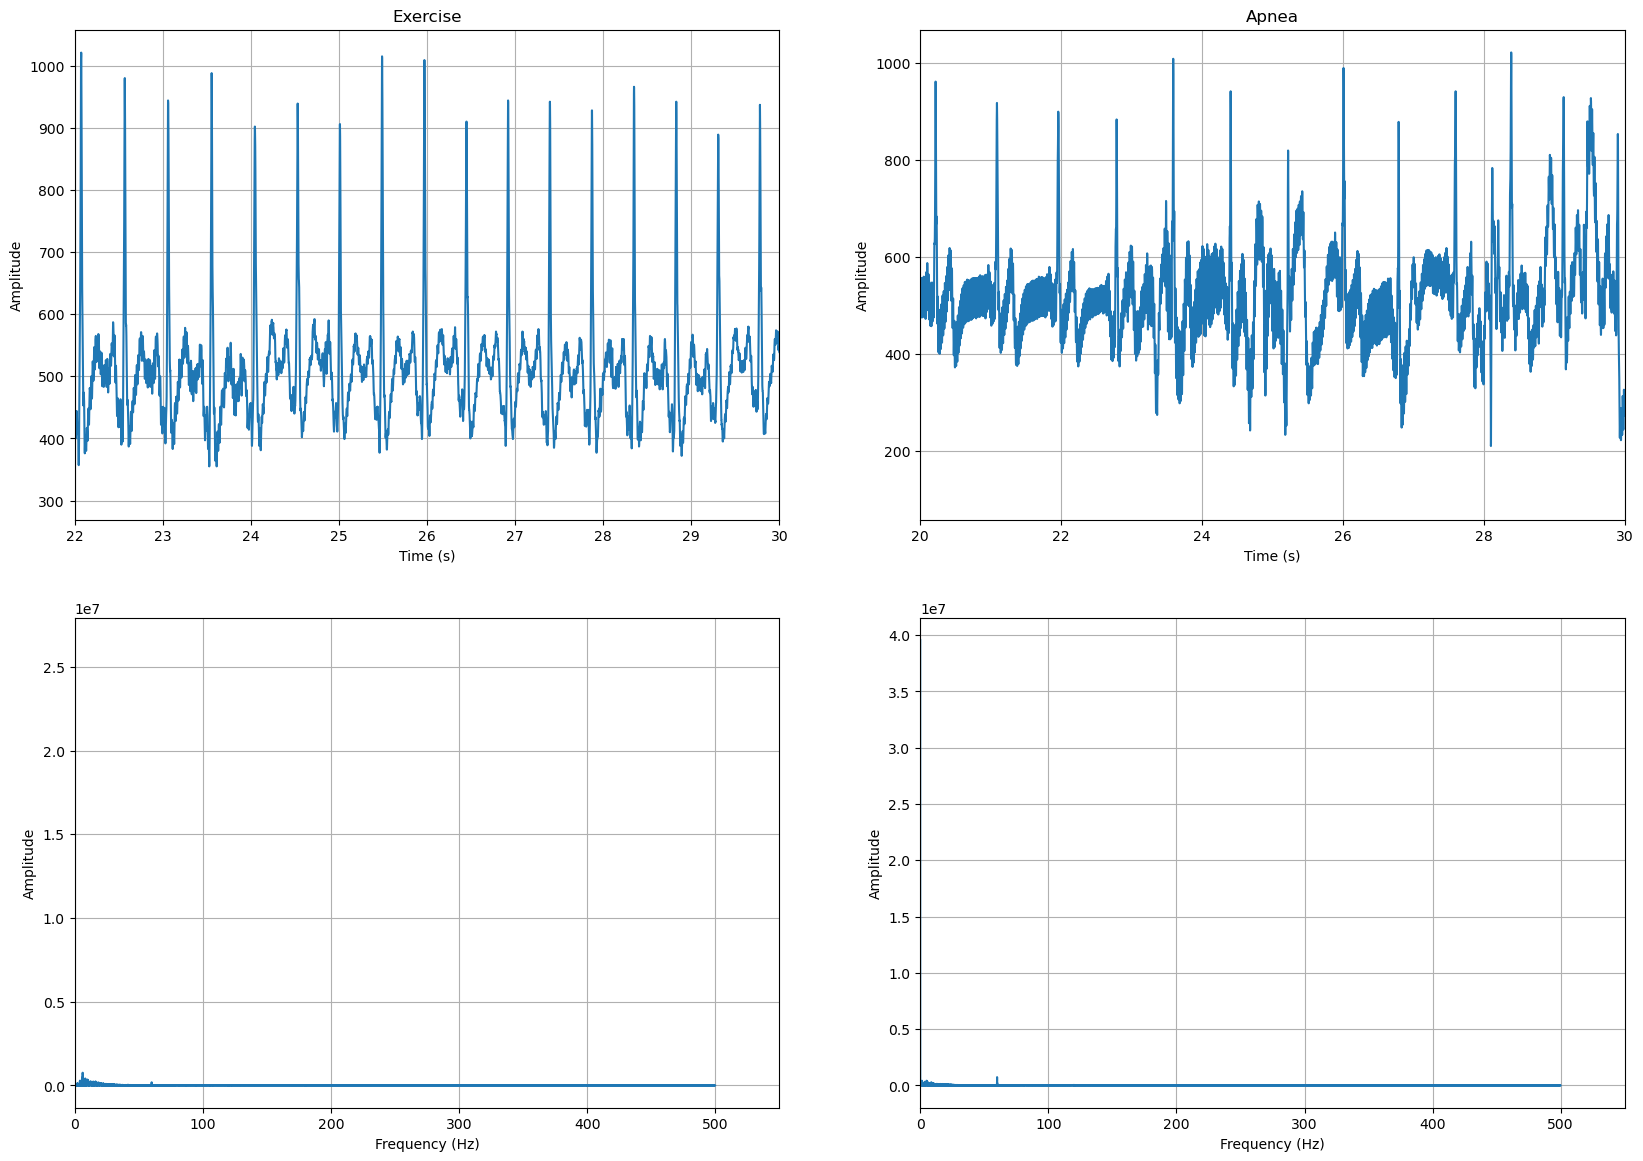

In [163]:
orden = 4
fs = 1000
fc = 50

t1,y1=read("ECG_1.txt",Fs)
freq1,amplitude1=fft(y1,Fs)
t3,y3=read("ECG_3.txt",Fs)
freq3,amplitude3=fft(y3,Fs)

_,y1fil=butterLow(orden,fc,fs,y1)
freq1fil,amplitude1fil=fft(y1fil,Fs)
_,y3fil=butterLow(orden,fc,fs,y3)
freq3fil,amplitude3fil=fft(y3fil,Fs)

plt.figure(figsize=(20, 14))

plt.subplot(2,2,1)
plot(t1,y1,"Exercise","Time (s)","Amplitude")
plt.xlim(22,30)
plt.grid()

plt.subplot(2,2,2)
plot(t3,y3,"Apnea","Time (s)","Amplitude")
plt.xlim(20,30)
plt.grid()

plt.subplot(2,2,3)
plot(freq1,np.abs(amplitude1),"","Frequency (Hz)","Amplitude")
plt.xlim(left=0)
plt.grid()

plt.subplot(2,2,4)
plot(freq3,np.abs(amplitude3),"","Frequency (Hz)","Amplitude")
plt.xlim(left=0)
plt.grid()

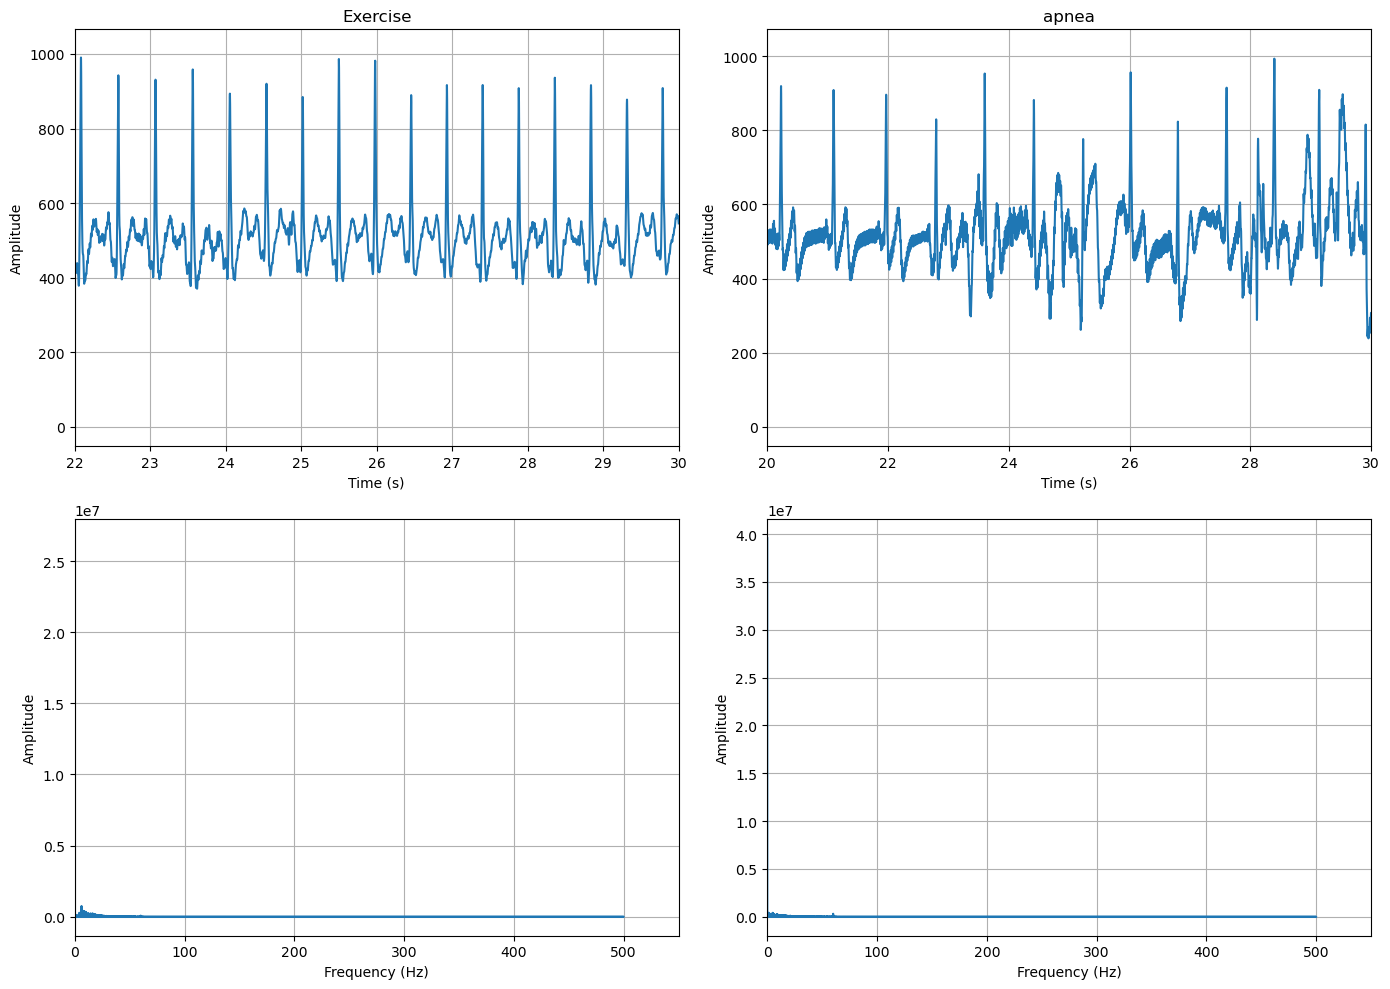

In [165]:
plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plot(t1,y1fil,"Exercise","Time (s)","Amplitude")

plt.xlim(22,30)
plt.grid()

plt.subplot(2,2,2)
plot(t3,y3fil,"apnea","Time (s)","Amplitude")

plt.xlim(20,30)
plt.grid()

plt.subplot(2,2,3)
plot(freq1fil,np.abs(amplitude1fil),"","Frequency (Hz)","Amplitude")
plt.xlim(left=0)
plt.grid()

plt.subplot(2,2,4)
plot(freq3fil,np.abs(amplitude3fil),"","Frequency (Hz)","Amplitude")
plt.xlim(left=0)
plt.grid()

plt.tight_layout()
plt.show()

Between IIR and FIR filters. One cannot be said to be better than the other overall, but Butterworth filters can be more efficient when looking to minimize filter order, while FIRs are preferred in applications where phase and stability are more important. 

I prefer to use Butterworth

EMG

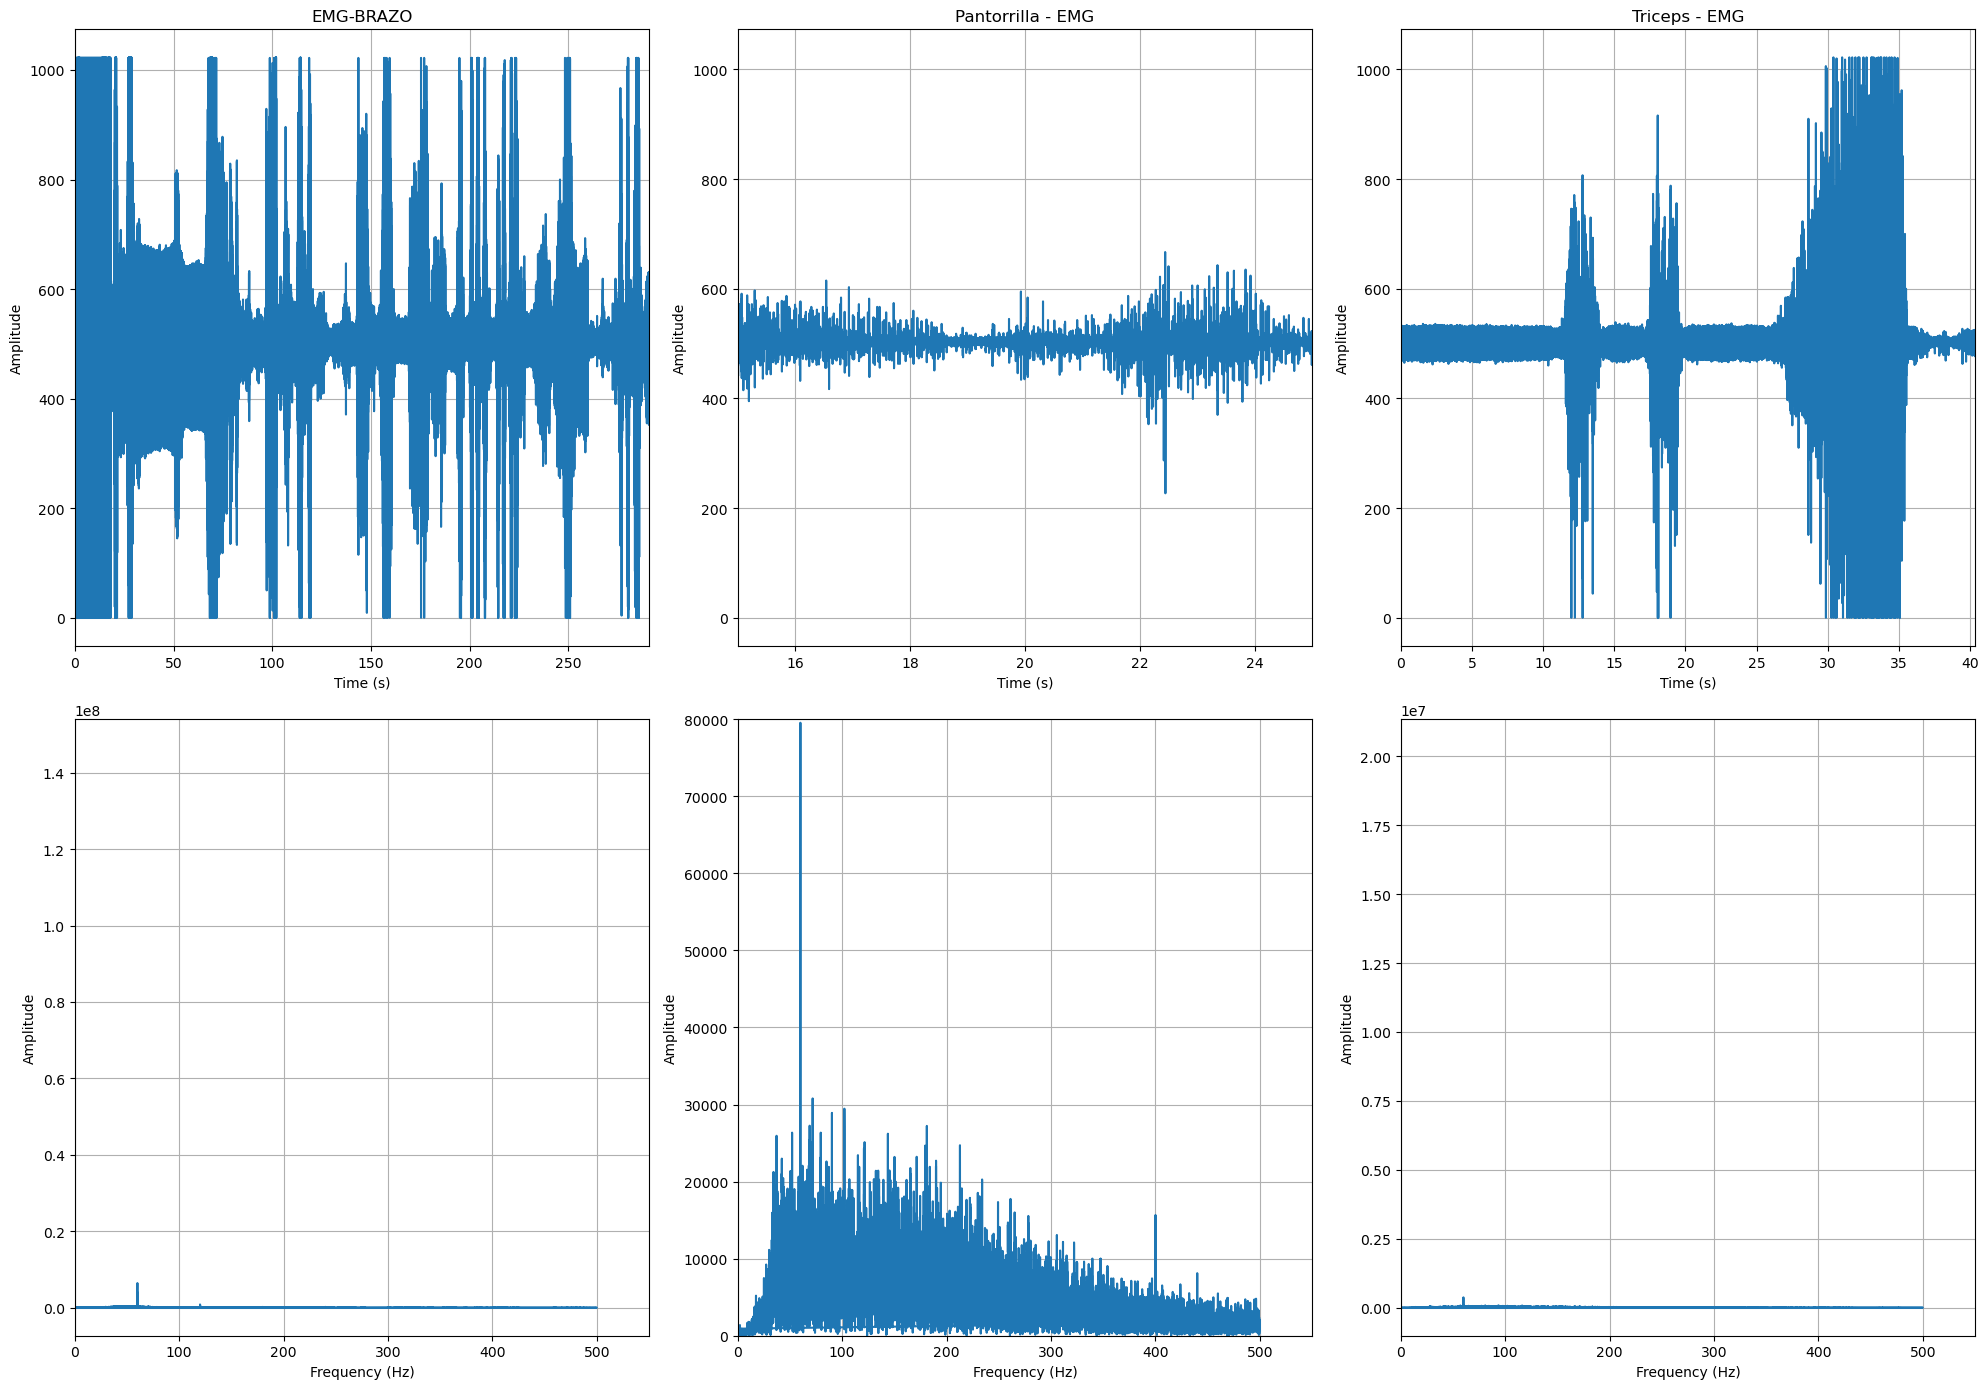

In [141]:
Fs=1000 #From Bitalino
tbrazo,ybrazo=read("brazo.txt",Fs)
freqbrazo,amplitudebrazo=fft(ybrazo,Fs)
tpantorrilla,ypantorrilla=read("pantoriilla.txt",Fs)
freqpantorrilla,amplitudepantorrilla=fft(ypantorrilla,Fs)
ttriceps,ytriceps=read("triceps.txt",Fs)
freqtriceps,amplitudetriceps=fft(ytriceps,Fs)

plt.figure(figsize=(20, 14))

plt.subplot(2,3,1)
plot(tbrazo,ybrazo,"EMG-BRAZO","Time (s)","Amplitude")
plt.autoscale(True, axis='x', tight=True)
plt.grid()

plt.subplot(2,3,2)
plot(tpantorrilla,ypantorrilla,"Pantorrilla - EMG","Time (s)","Amplitude")
plt.autoscale(True, axis='x', tight=True)
plt.xlim(15,25)
plt.grid()

plt.subplot(2,3,3)
plot(ttriceps,ytriceps,"Triceps - EMG","Time (s)","Amplitude")
plt.autoscale(True, axis='x', tight=True)
plt.grid()

plt.subplot(2,3,4)
plot(freqbrazo,np.abs(amplitudebrazo),"","Frequency (Hz)","Amplitude")
plt.xlim(left=0)
plt.grid()

plt.subplot(2,3,5)
plot(freqpantorrilla,np.abs(amplitudepantorrilla),"","Frequency (Hz)","Amplitude")
plt.xlim(left=0)
plt.ylim(0,80000)
plt.grid()

plt.subplot(2,3,6)
plot(freqtriceps,np.abs(amplitudetriceps),"","Frequency (Hz)","Amplitude")
plt.xlim(left=0)
plt.grid()

plt.tight_layout()
plt.show()

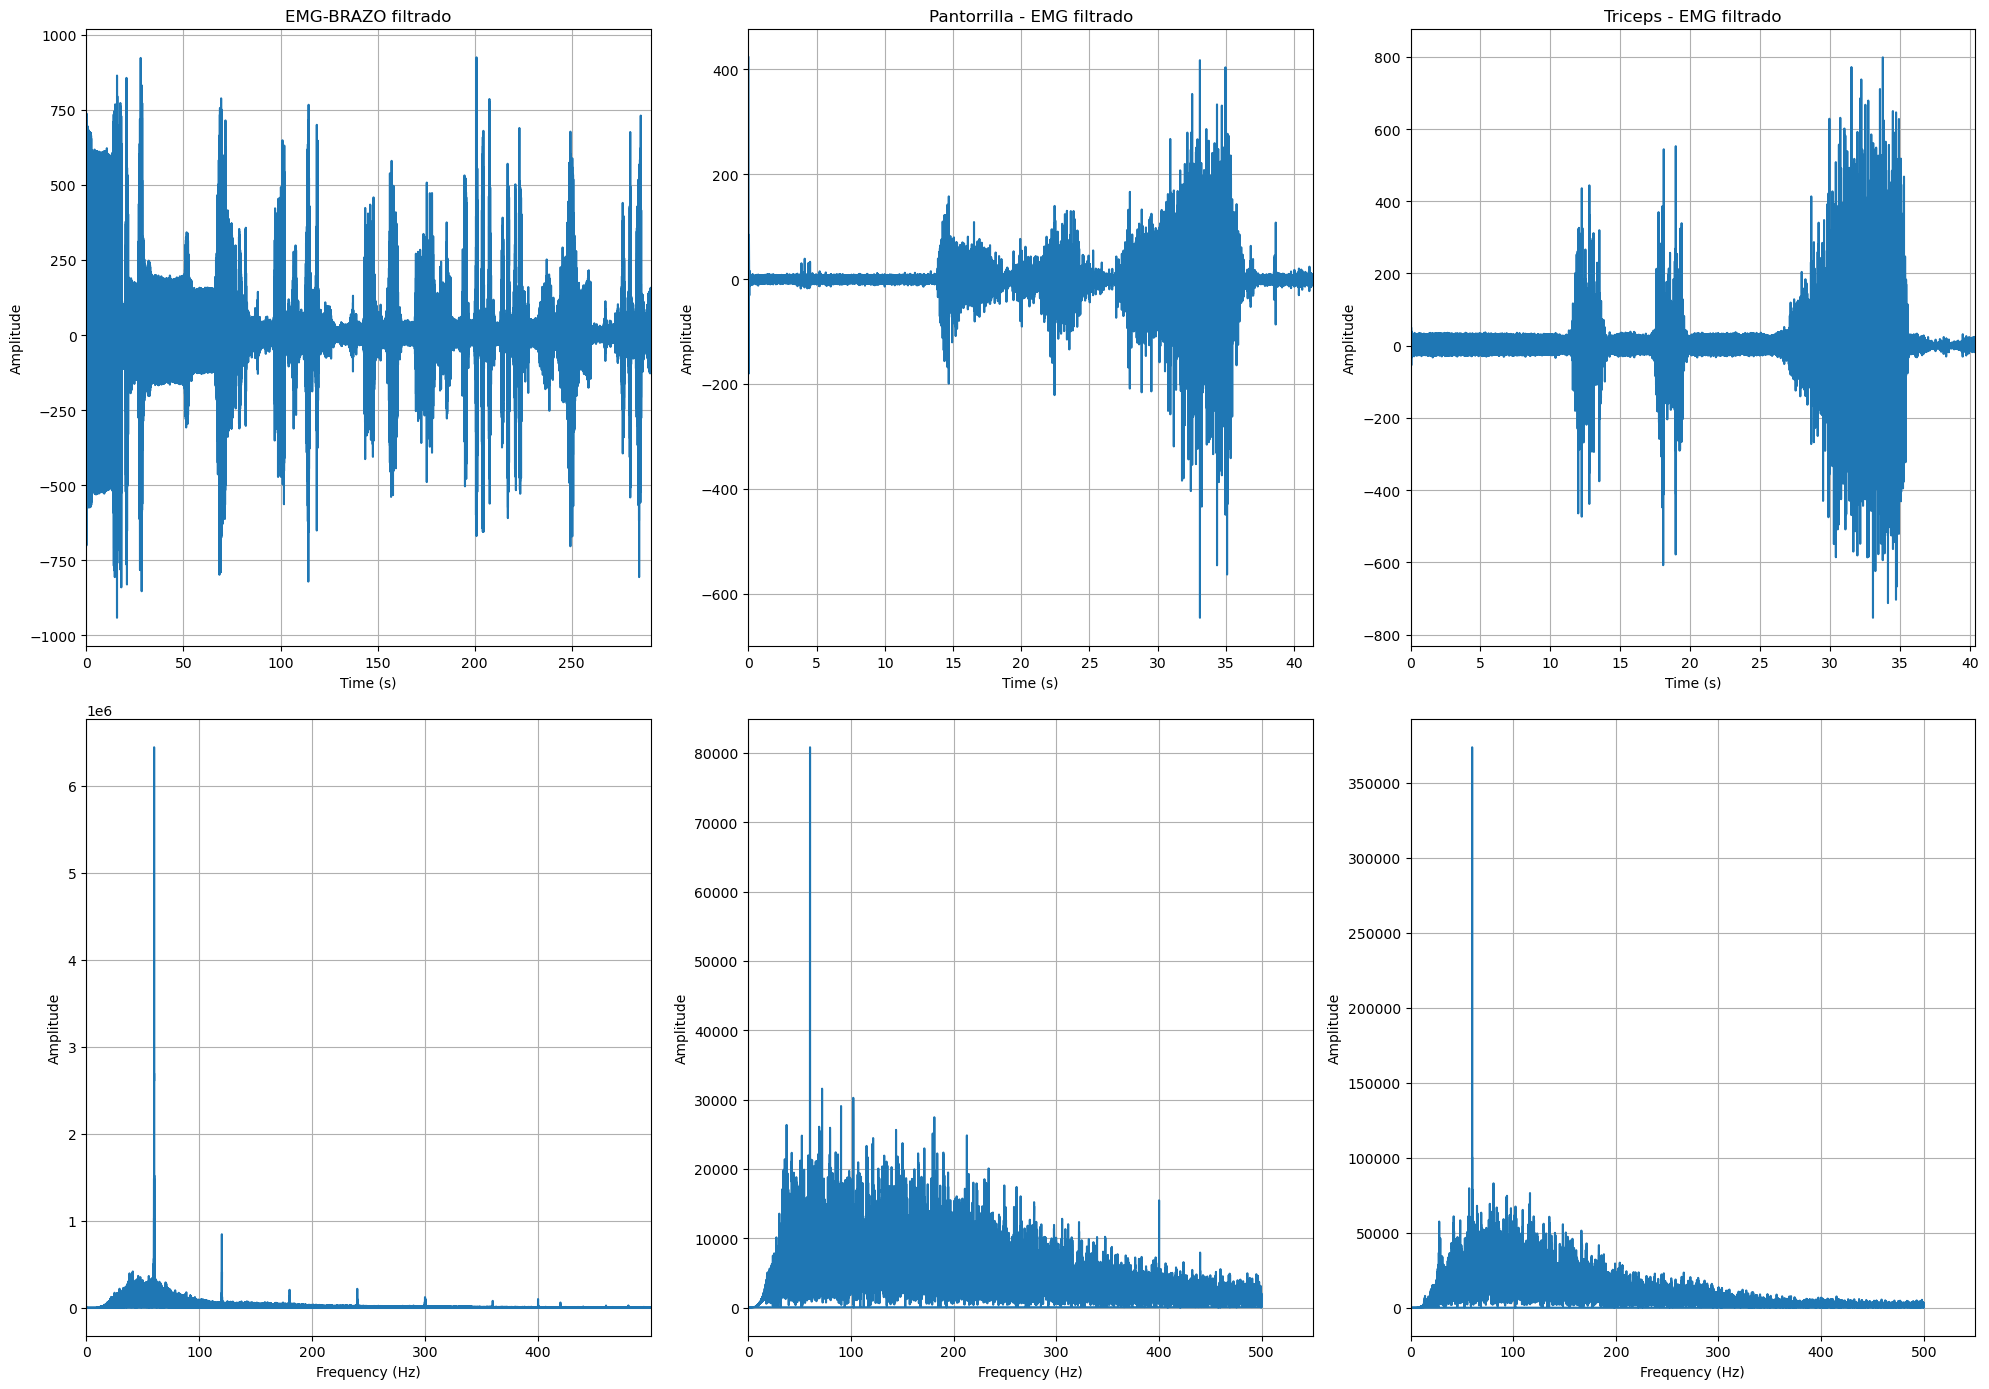

In [142]:
LowFc=20
HighFc=499.9
order=4
_,_,brazo_fil=bandPassFilter_IIR(LowFc,HighFc,order,Fs,ybrazo)
_,_,pantorrilla_fil=bandPassFilter_IIR(LowFc,HighFc,order,Fs,ypantorrilla)
_,_,triceps_fil=bandPassFilter_IIR(LowFc,HighFc,order,Fs,ytriceps)

freqbrazofil,amplitudebrazofil=fft(brazo_fil,Fs)
freqpantorrillafil,amplitudepantorrillafil=fft(pantorrilla_fil,Fs)
freqtricepsfil,amplitudetricepsfil=fft(triceps_fil,Fs)

plt.figure(figsize=(20, 14))

plt.subplot(2,3,1)
plot(tbrazo,brazo_fil,"EMG-BRAZO filtrado","Time (s)","Amplitude")
plt.autoscale(True, axis='x', tight=True)
plt.grid()

plt.subplot(2,3,2)
plot(tpantorrilla,pantorrilla_fil,"Pantorrilla - EMG filtrado","Time (s)","Amplitude")
plt.autoscale(True, axis='x', tight=True)
plt.grid()

plt.subplot(2,3,3)
plot(ttriceps,triceps_fil,"Triceps - EMG filtrado","Time (s)","Amplitude")
plt.autoscale(True, axis='x', tight=True)
plt.grid()

plt.subplot(2,3,4)
plot(freqbrazofil,np.abs(amplitudebrazofil),"","Frequency (Hz)","Amplitude")
plt.autoscale(True, axis='x', tight=True)
plt.xlim(left=0)
plt.grid()

plt.subplot(2,3,5)
plot(freqpantorrillafil,np.abs(amplitudepantorrillafil),"","Frequency (Hz)","Amplitude")
plt.xlim(left=0)
plt.grid()

plt.subplot(2,3,6)
plot(freqtricepsfil,np.abs(amplitudetricepsfil),"","Frequency (Hz)","Amplitude")
plt.xlim(left=0)
plt.grid()

plt.tight_layout()
plt.show()

When analyzing the frequency spectrum of the EMG signal prior to filtering, a prominent energy concentration is observed at around 20 Hz, suggesting the presence of unwanted artifacts or components at low frequencies, possibly associated with motion or mechanical interference. After applying the corresponding filter, these frequencies close to 20 Hz are significantly attenuated, allowing a better visualization of the higher frequency components in the spectrum. This reduction in low frequencies improves the resolution of variations in other relevant frequencies, making it easier to identify muscle activity in the typical range of 20 Hz to 500 Hz, which was not clearly visible in the raw spectrum.